<center><h1>1-e: Transformers</h1></center>
<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>


# Warning :
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.

In this notebook, we will implement the first Visual Transformer, [ViT](https://arxiv.org/abs/2010.11929). We'll implement a naive version of it, much smaller than the ones described in the paper, and we also won't use complex data augmentation and regularizations. But note that this is important to make transformers work in practice on large-scale dataset.

To get a gist of what is required to make a transformer work in practice, have a look at the [DeiT and CaiT codebase](https://github.com/facebookresearch/deit).

This notebook is a simplified version of the excellent [Timm library](https://github.com/rwightman/pytorch-image-models).

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.utils as vutils
import torchvision
from PIL import Image

Let's load the MNIST dataset:

In [4]:
transform = transforms.Compose([
  transforms.ToTensor()
])

train_dataset = torchvision.datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

100%|██████████| 9912422/9912422 [00:00<00:00, 108858598.16it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 41799756.32it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 28340565.00it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4495169.60it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



... and visualize!

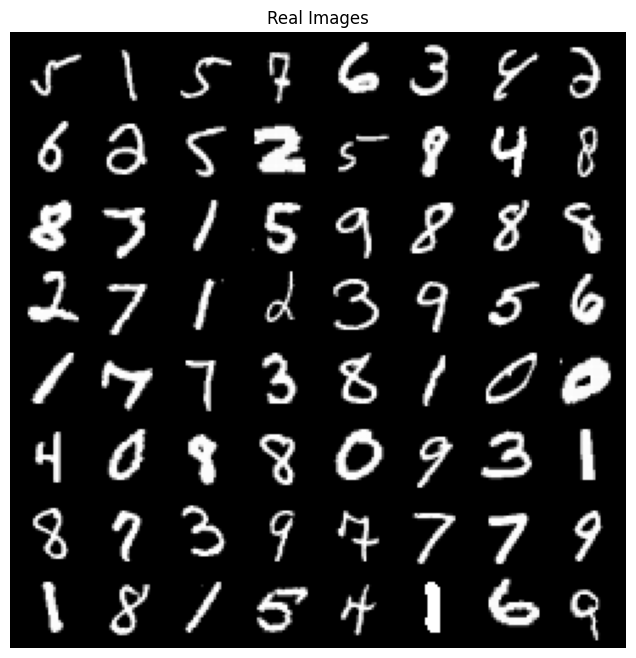

In [5]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images")
plt.imshow(vutils.make_grid(real_batch[0][:64], normalize=True).permute(1,2,0))
plt.show()

# Here is the general architecture of the ViT model
## The architecture includes:
- A step for splitting the image into disjoint patches with a linear projection of the patches
- Positional encoding to capture the absolute spatial information of each patch in the image
- The addition of a "[CLS]" token, initialized randomly and learned during training
- A transformer encoder that learns the representation of each token
- A classification head that performs class prediction from the re-embedded [CLS] token at the output of the encoder

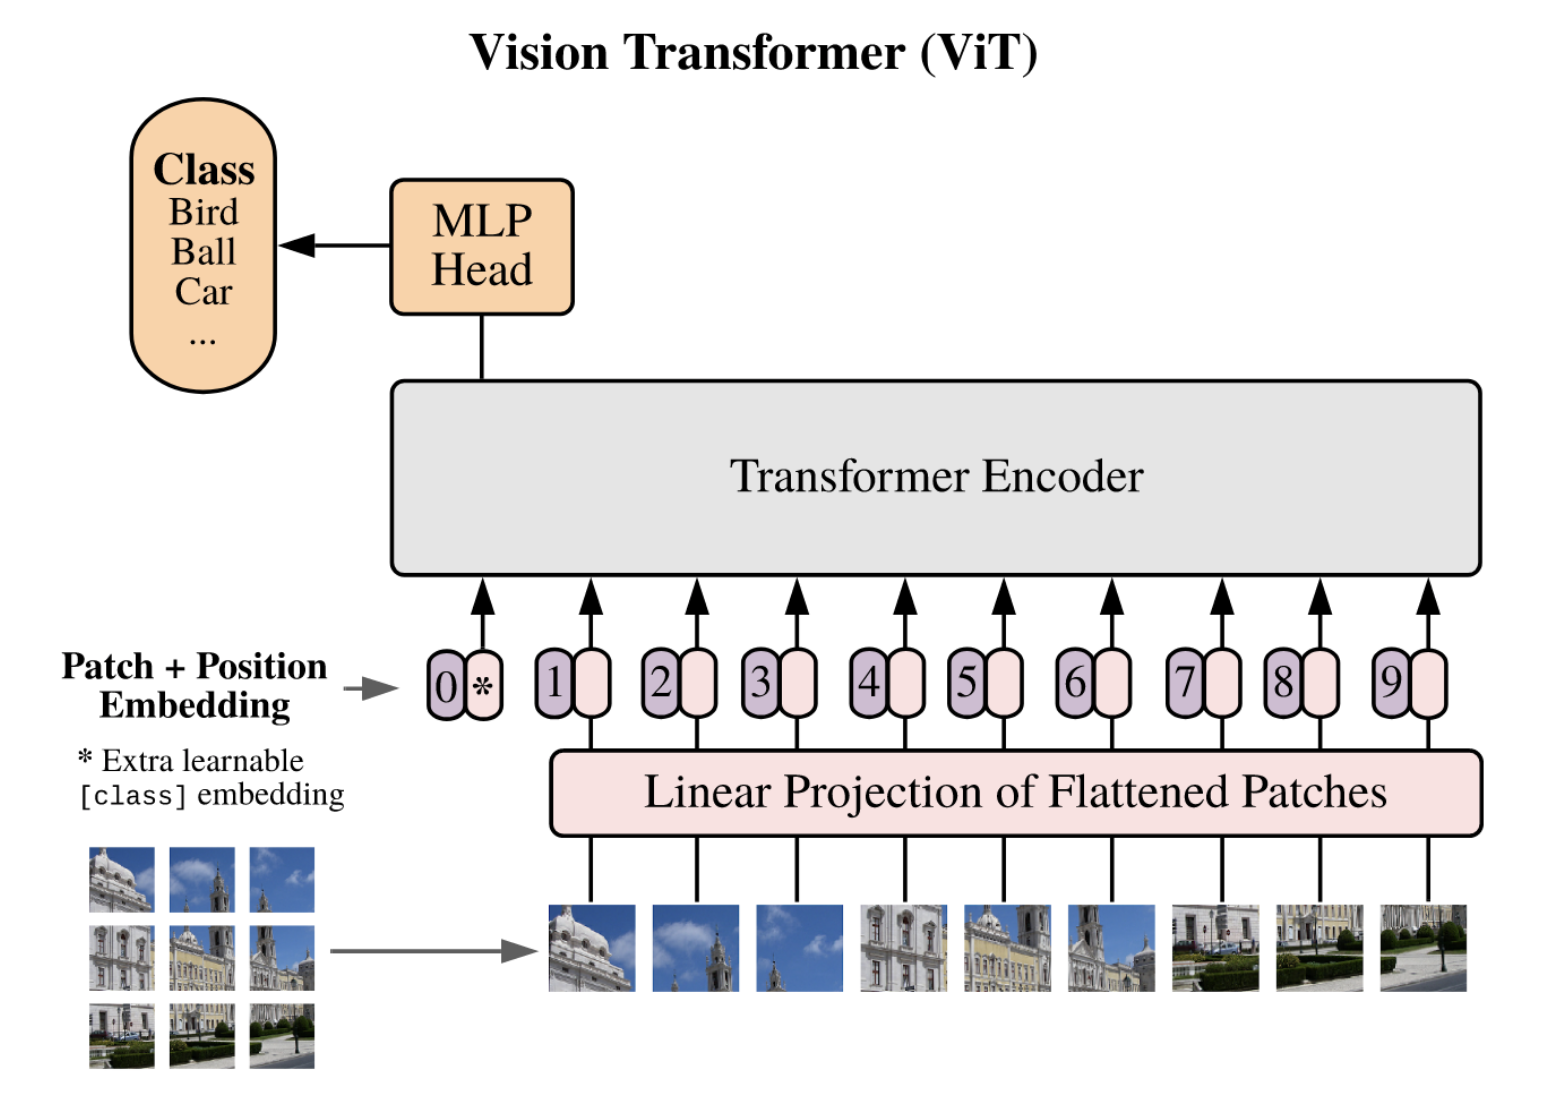

# Linear Projection of flattened patches

**Q1**:
First, we need to code the patch embedding. In NLP, it could be using a word2vec embeddings, but we need something different in Computer Vision.

You are going to use a specific 2d convolution to play the role of the so-called "Linear Projection" on the image above and process each patch independently without overlap. Think a bit how you could do that.

Then, you need to manipulate the dimensions of the resulting tensor to get a final tensor of shape `(batch_size, nb_tokens, embedding_dim)`. *Hint: You will need a `view/reshape` and `transpose/permute` operators*.

As usual, remember to check the output shape of your layer by trying with a random tensor!

B x C x H x W -> B x N x C  
N = HxW

In [6]:
class PatchEmbed(nn.Module):
  def __init__(self, in_chan=1, patch_size=7, embed_dim=128):
    super().__init__()
    ## TODO
    self.projection = nn.Conv2d(in_chan, embed_dim, (patch_size, patch_size), stride=patch_size, padding=0 )

  def forward(self, x):
    x = self.projection(x)

    B, C, H, W = x.shape
    ## TODO
    x = torch.reshape(x,(B,C,-1)) #BxCxN
    x = torch.transpose(x, 1, 2)
    #x.shape() -> B, N, C
    return x


In [7]:
p = PatchEmbed()
x = real_batch[0][0:2]
print(x.shape)
x = p.forward(x)
print(x.shape)


torch.Size([2, 1, 28, 28])
torch.Size([2, 16, 128])


# Transformer encoder

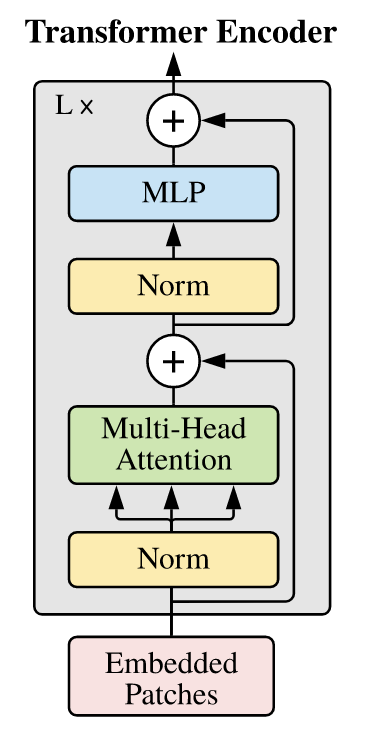

## Q2: MLP

Now we need to build a transformer block. Let's first build the easiest part, the MLP! By now, you should be confident how to code one.

Code a MLP with one hidden layer. Note that the input and output dimensions will be the same. Instead of ReLU, use the activation GELU, which is a slight alternative often used for transformers.

In [8]:
class MLP(nn.Module):
  def __init__(self, in_features, hid_features):
    super().__init__()
    # TODO
    self._in_features = in_features
    self._hid_features = hid_features
    self._mlp = nn.Sequential(
        nn.Linear(in_features, hid_features),
        nn.GELU(),
        nn.Linear(hid_features, in_features)
    )

  def forward(self, x):
    # TODO
    x = self._mlp(x)
    return x


MLP(128, 512)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

## Q3: Self-attention

Now we are going to build the famous **Self-Attention**.
- What is the main feature of self-attention, especially compared to its convolutional counterpart. What is its main challenge in terms of computation/memory?
- At first, we are going to only consider the simple case of one head. Write the equations and complete the following code. And don't forget a final linear projection at the end!




The main feature in self attention is full interraction between all patches ( in convolution the receptive field is possibly not on all image)


In [9]:
class SelfAttention(nn.Module):
  def __init__(self, embed_dim):
    super().__init__()
    # TODO
    self._embed_dim = torch.tensor(embed_dim, requires_grad=False)
    self.lin_k = nn.Linear(embed_dim, embed_dim, bias=False)
    self.lin_q = nn.Linear(embed_dim, embed_dim, bias=False)
    self.lin_v = nn.Linear(embed_dim, embed_dim, bias=False)
    self.soft = nn.Softmax(dim=1)
    self.lin_final = nn.Linear(embed_dim, embed_dim)

  def forward(self, x):
    B, N, C = x.shape

    # TODO: compute the Q, K, V
    q = self.lin_q(x)
    k = self.lin_k(x)
    v = self.lin_v(x)

    # TODO: compute the attention matrix using Q and K
    attention = self.soft(torch.div(q @ torch.transpose(k, dim0=1, dim1=2), torch.sqrt(self._embed_dim)))


    # TODO: compute the final version using the attention,
    # V, and the final projection
    x = self.lin_final( attention @ v )

    return x


SelfAttention(128)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

# Q4 : Multi-head self-attention

Now we need to build a Multi-Heads Self-Attention.
- Write the equations and complete the following code to build a Multi-Heads Self-Attention.
- The total embedding size will be shared equally among all heads.

In [10]:
class MultiHeadsSelfAttention(nn.Module):
  def __init__(self, embed_dim, num_heads):
    super().__init__()

    self.head_dim = embed_dim // num_heads
    self.scale = self.head_dim ** -0.5
    self.num_heads = num_heads

    self.q = nn.Linear(embed_dim, embed_dim, bias=False)
    self.k = nn.Linear(embed_dim, embed_dim, bias=False)
    self.v = nn.Linear(embed_dim, embed_dim, bias=False)
    self.projection = nn.Linear(embed_dim, embed_dim)

    self.soft = nn.Softmax(dim=2)

  def forward(self, x):
    B, N, C = x.shape #B : batch, N : nb de patchs, C : taille embedding

    # You need to reshape and permute dimension in a certain manner
    # so that each head (C // num_heads) interact
    # only with its dimensions and not other heads.

    # Try to write at each operation the shape of the tensor if you
    # feel confused.

    # TODO

    q = self.q(x)
    k = self.k(x)
    v = self.v(x)

    q = x.reshape(B, N, self.num_heads, self.head_dim)
    q = torch.transpose(q, 1, 2)

    k = x.reshape(B, N, self.num_heads, self.head_dim)
    k = torch.transpose(k, 1, 2)

    v = x.reshape(B, N, self.num_heads, self.head_dim)
    v = torch.transpose(v, 1, 2)

    att_QK = self.soft(q @ torch.transpose(k, dim0=2, dim1=3) * self.scale)

    att = att_QK @ v

    x = torch.transpose(att, 2, 1)
    x = x.reshape(B, N, C)

    x = self.projection(x)

    return x


MultiHeadsSelfAttention(128, 2)(x).shape

torch.Size([2, 16, 128])

# Q5: Transfomer block

Now, we need to build a Transformer **Block** as described in the image below.
- Write the equations and complete the following code.
- For the Layer Normalization, use PyTorch LayerNorm: https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html

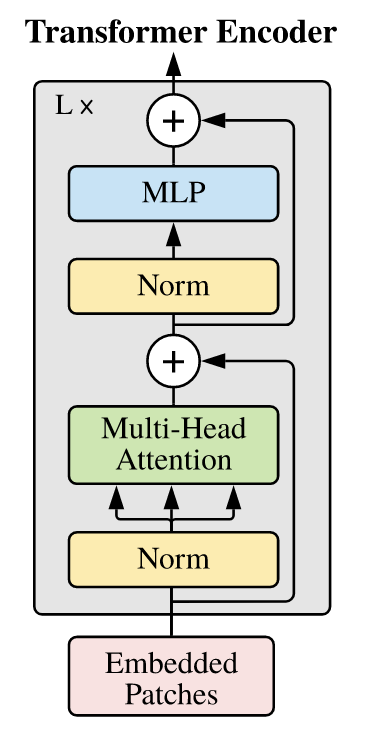

In [11]:
class Block(nn.Module):
  def __init__(self, embed_dim, num_heads=4, mlp_ratio=4):
    super().__init__()
    # TODO
    self._embed_dim = embed_dim
    self._num_heads = num_heads
    self._mlp_ratio = mlp_ratio
    self._layer_norm1 = nn.LayerNorm(self._embed_dim)
    self._layer_norm2 = nn.LayerNorm(self._embed_dim)
    self._attention = MultiHeadsSelfAttention(self._embed_dim, self._num_heads) #SelfAttention(self._embed_dim)
    self._mlp = MLP(self._embed_dim, self._embed_dim//self._mlp_ratio)

  def forward(self, x):
    # TODO
    x_norm = self._layer_norm1(x)
    x_att = self._attention(x_norm)
    x_sum = x_att + x
    x_att2 = self._layer_norm2(x_sum)
    x_mlp = self._mlp(x_att2)
    x = x_mlp + x_sum
    return x

Block(128)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

# Q6: Full ViT model

Now you need to build a ViT model based on what you coded in the previous questions. There are additional components that should be coded such as the Class token, Positional embedding and the classification head.

- Explain what is a Class token and why we use it? \\
- Explain what is the the positional embedding (PE) and why it is important? \\

For PE, you can use a sinusoidal encoding (see below), or fully learned.


### Sinusoidal PE


In [12]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(1,sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[0][i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

In [13]:
DEVICE = "cpu"

class ViT(nn.Module):
  def __init__(self, embed_dim, nb_blocks, patch_size, nb_classes=10):
    super().__init__()

    self.nb_classes = nb_classes

    num_patches = (28 // patch_size) ** 2
    self.class_token = nn.Parameter(torch.randn(1,1,embed_dim))
    if DEVICE == "cuda:0":
      self.pos_embed = get_positional_embeddings(num_patches+1, embed_dim).cuda()
    else :
      self.pos_embed = get_positional_embeddings(num_patches+1, embed_dim)
    self.patch_embed = PatchEmbed(patch_size=patch_size, embed_dim=embed_dim)

    blocks = []
    for _ in range(nb_blocks):
      blocks.append(
          Block(embed_dim)
      )
    self.blocks = nn.Sequential(*blocks)

    self.norm = nn.LayerNorm(embed_dim)
    self.head = nn.Sequential(
                  nn.Linear(embed_dim, embed_dim//2),
                  nn.Sigmoid(),
                  nn.Linear(embed_dim//2, self.nb_classes)
                )
    self.soft = nn.Softmax(dim=1)

  def forward(self, x):
    x = self.patch_embed(x) ## image to patches
    batch, N, D = x.shape

    ## concatenating class token
    class_tokens = self.class_token.expand(batch, -1, -1)
    x = torch.cat((class_tokens, x), dim=1)

    ## adding positional embedding
    x = x + self.pos_embed

    ## forward in the transformer
    x = self.blocks(x)

    ## Normalize the output
    x = self.norm(x)
    output = self.soft(self.head(x[:,0,:])) ## classification output

    return output


ViT(128, 3, 7)(torch.randn(32, 1, 28, 28)).shape

torch.Size([32, 10])

# Q7: Experiment on MNIST!

A quick function to evaluate our model:

In [14]:
@torch.no_grad()
def eval_model(model, loader):
  model.eval()
  acc = 0.
  c = 0

  for x, y in loader:
    x, y = x.cuda(), y.cuda()
    yhat = model(x)

    acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
    c += len(x)

  model.train()
  return round(100 * acc / c, 2)

And run! Feel free to try other hyperparameters.

In [15]:
import matplotlib.pyplot as plt

--- Epoch 0 ---
Train loss: 2.1183463965397653
--- Epoch 1 ---
Train loss: 1.8930677373780371
--- Epoch 2 ---
Train loss: 1.7869613521388854
--- Epoch 3 ---
Train loss: 1.7421360259879626
--- Epoch 4 ---
Train loss: 1.7305361235828034
--- Epoch 5 ---
Train loss: 1.7201031652340757
--- Epoch 6 ---
Train loss: 1.7138847331248366
--- Epoch 7 ---
Train loss: 1.6567340509723754
--- Epoch 8 ---
Train loss: 1.5885223739945304
--- Epoch 9 ---
Train loss: 1.5682872688846548
Test accuracy: 91.63


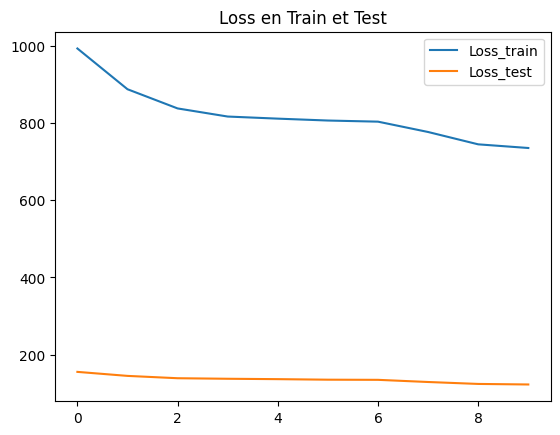

In [16]:
epochs = 10

DEVICE = "cuda:0"

embed_dim = 32
patch_size = 7
nb_blocks = 2

model = ViT(embed_dim, nb_blocks, patch_size).cuda()

opt = torch.optim.Adam(model.parameters())

train_loss_liste = []
test_loss_liste = []
for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()

    opt.zero_grad()
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()
  train_loss_liste.append(train_loss)
  with torch.no_grad():
    test_loss = 0
    for x, y in test_loader:
      x, y = x.cuda(), y.cuda()
      yhat = model(x)
      loss = F.cross_entropy(yhat, y)
      test_loss += loss.item()
    test_loss_liste.append(test_loss)

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")
acc = eval_model(model, test_loader)
print(f"Test accuracy: {acc}")

plt.figure()
plt.plot(train_loss_liste, label='Loss_train')
plt.plot(test_loss_liste, label='Loss_test')
plt.title('Loss en Train et Test')
plt.legend()
plt.show()

# Experimental analysis
- Test different hyperparameters and explain how they affect the performance. In particular embed_dim, patch_size, and nb_blocks.
- Comment and discuss the final performance that you get. How to improve it?
-  What is the complexity of the transformer in terms of number of tokens? How you can improve it?

--- Epoch 0 ---
Train loss: 2.23396197107555
--- Epoch 1 ---
Train loss: 2.0801451704395353
--- Epoch 2 ---
Train loss: 1.973570354457603
--- Epoch 3 ---
Train loss: 1.8935236465702179
--- Epoch 4 ---
Train loss: 1.8373924684422864
--- Epoch 5 ---
Train loss: 1.8020420496397689
--- Epoch 6 ---
Train loss: 1.7790974856439683
--- Epoch 7 ---
Train loss: 1.7485769361829453
--- Epoch 8 ---
Train loss: 1.716909577597433
--- Epoch 9 ---
Train loss: 1.7014744393606938
Test accuracy [16, 32, 64], 7, 2 : 79.28


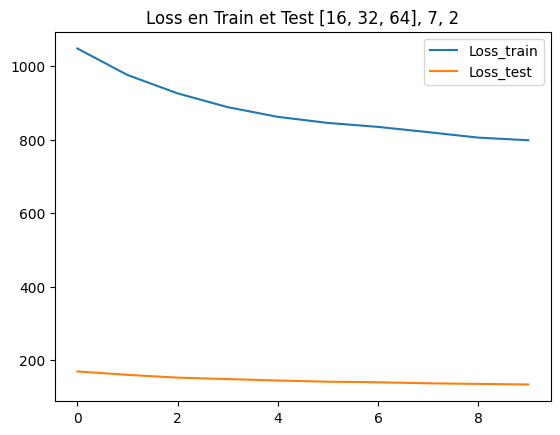

--- Epoch 0 ---
Train loss: 2.156655739619534
--- Epoch 1 ---
Train loss: 2.006035967168015
--- Epoch 2 ---
Train loss: 1.8877834030814262
--- Epoch 3 ---
Train loss: 1.7715950751863818
--- Epoch 4 ---
Train loss: 1.7313561487807902
--- Epoch 5 ---
Train loss: 1.6685197460117625
--- Epoch 6 ---
Train loss: 1.6498049792450373
--- Epoch 7 ---
Train loss: 1.6370131956743026
--- Epoch 8 ---
Train loss: 1.6316837501932564
--- Epoch 9 ---
Train loss: 1.6257785187601281
Test accuracy [16, 32, 64], 7, 2 : 85.13


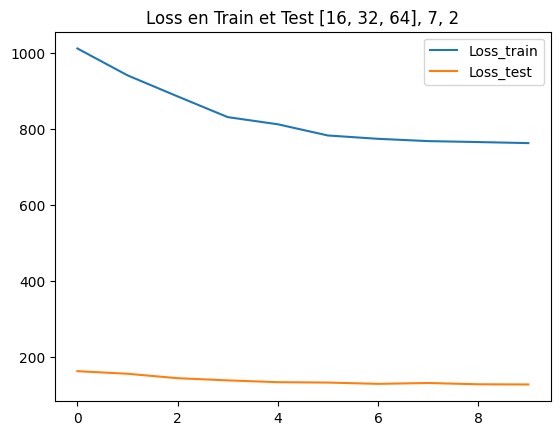

--- Epoch 0 ---
Train loss: 2.0506859308621013
--- Epoch 1 ---
Train loss: 1.7965104175783169
--- Epoch 2 ---
Train loss: 1.6948045375250549
--- Epoch 3 ---
Train loss: 1.64294316646641
--- Epoch 4 ---
Train loss: 1.6288968695760535
--- Epoch 5 ---
Train loss: 1.6185721535164157
--- Epoch 6 ---
Train loss: 1.6143305044946894
--- Epoch 7 ---
Train loss: 1.603355686293482
--- Epoch 8 ---
Train loss: 1.553970791891948
--- Epoch 9 ---
Train loss: 1.5406062613163929
Test accuracy [16, 32, 64], 7, 2 : 93.27


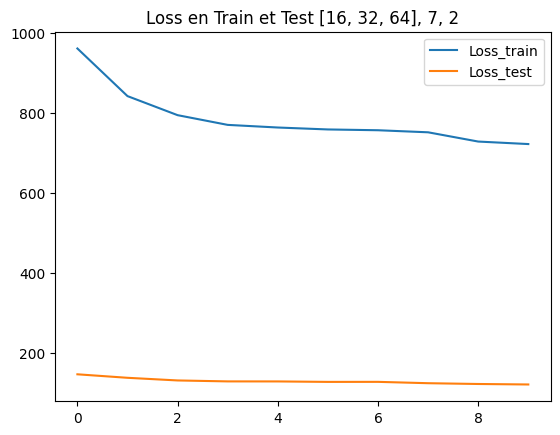

In [21]:
epochs = 10

DEVICE = "cuda:0"

embed_dims = [16,32,64]
patch_size = 7
nb_blocks= 2
for embed_dim in embed_dims:
  model = ViT(embed_dim, nb_blocks, patch_size).cuda()

  opt = torch.optim.Adam(model.parameters())

  train_loss_liste = []
  test_loss_liste = []
  for epoch in range(epochs):
    train_loss = 0.
    for x, y in train_loader:
      x, y = x.cuda(), y.cuda()

      opt.zero_grad()
      yhat = model(x)
      loss = F.cross_entropy(yhat, y)
      loss.backward()

      opt.step()

      train_loss += loss.item()
    train_loss_liste.append(train_loss)
    with torch.no_grad():
      test_loss = 0
      for x, y in test_loader:
        x, y = x.cuda(), y.cuda()
        yhat = model(x)
        loss = F.cross_entropy(yhat, y)
        test_loss += loss.item()
      test_loss_liste.append(test_loss)

    print(f"--- Epoch {epoch} ---")
    print(f"Train loss: {train_loss / len(train_loader)}")
  acc = eval_model(model, test_loader)
  print(f"Test accuracy {embed_dims}, {patch_size}, {nb_blocks} : {acc}")

  plt.figure()
  plt.plot(train_loss_liste, label='Loss_train')
  plt.plot(test_loss_liste, label='Loss_test')
  plt.title(f'Loss en Train et Test {embed_dims}, {patch_size}, {nb_blocks}')
  plt.legend()
  plt.show()

--- Epoch 0 ---
Train loss: 2.0298017992902158
--- Epoch 1 ---
Train loss: 1.7556327256058324
--- Epoch 2 ---
Train loss: 1.721586792453774
--- Epoch 3 ---
Train loss: 1.710220801804874
--- Epoch 4 ---
Train loss: 1.7006042250183855
--- Epoch 5 ---
Train loss: 1.6457373483348756
--- Epoch 6 ---
Train loss: 1.6162085685648644
--- Epoch 7 ---
Train loss: 1.6083900623484206
--- Epoch 8 ---
Train loss: 1.593856107451514
--- Epoch 9 ---
Train loss: 1.5389926087881711
Test accuracy 32, 4, 2 : 92.94


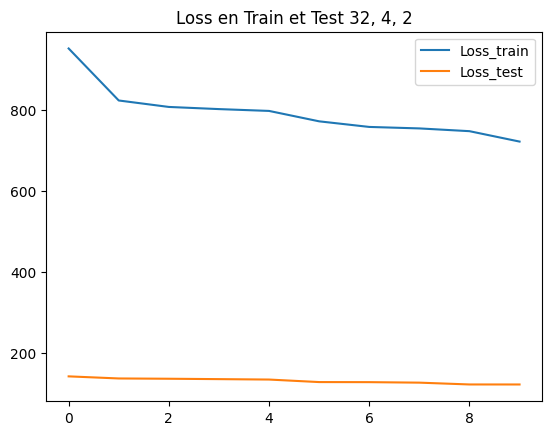

--- Epoch 0 ---
Train loss: 2.0500719153296463
--- Epoch 1 ---
Train loss: 1.8602367273525897
--- Epoch 2 ---
Train loss: 1.697370747004999
--- Epoch 3 ---
Train loss: 1.6444782283006192
--- Epoch 4 ---
Train loss: 1.630739823841591
--- Epoch 5 ---
Train loss: 1.6220161856364594
--- Epoch 6 ---
Train loss: 1.6148088400297835
--- Epoch 7 ---
Train loss: 1.6113621964891836
--- Epoch 8 ---
Train loss: 1.5748086753430397
--- Epoch 9 ---
Train loss: 1.5436834839107132
Test accuracy 32, 7, 2 : 90.91


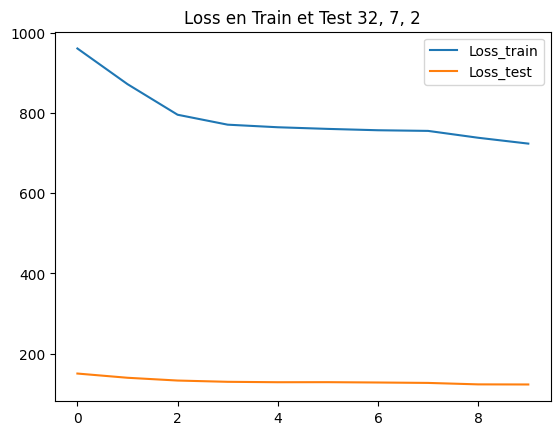

--- Epoch 0 ---
Train loss: 1.8946819409632734
--- Epoch 1 ---
Train loss: 1.6660865118254478
--- Epoch 2 ---
Train loss: 1.6039112493681755
--- Epoch 3 ---
Train loss: 1.549501933777002
--- Epoch 4 ---
Train loss: 1.517816731670518
--- Epoch 5 ---
Train loss: 1.5100095180560276
--- Epoch 6 ---
Train loss: 1.5043036129428888
--- Epoch 7 ---
Train loss: 1.5028809865654658
--- Epoch 8 ---
Train loss: 1.5005088223577308
--- Epoch 9 ---
Train loss: 1.4981048404534996
Test accuracy 32, 14, 2 : 96.7


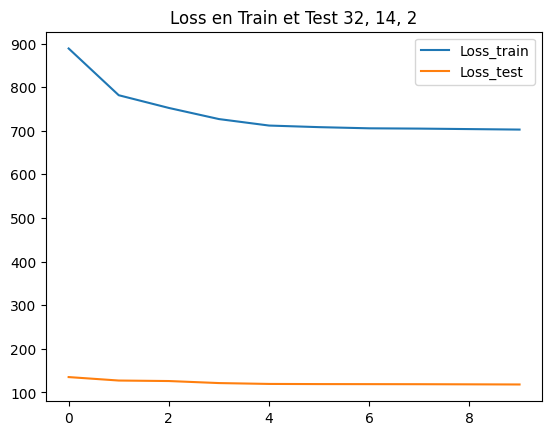

In [22]:
epochs = 10

DEVICE = "cuda:0"

embed_dims = 32
patch_sizes = [4,7,14]
nb_blocks= 2

for patch_size in patch_sizes:
  model = ViT(embed_dim, nb_blocks, patch_size).cuda()

  opt = torch.optim.Adam(model.parameters())

  train_loss_liste = []
  test_loss_liste = []
  for epoch in range(epochs):
    train_loss = 0.
    for x, y in train_loader:
      x, y = x.cuda(), y.cuda()

      opt.zero_grad()
      yhat = model(x)
      loss = F.cross_entropy(yhat, y)
      loss.backward()

      opt.step()

      train_loss += loss.item()
    train_loss_liste.append(train_loss)
    with torch.no_grad():
      test_loss = 0
      for x, y in test_loader:
        x, y = x.cuda(), y.cuda()
        yhat = model(x)
        loss = F.cross_entropy(yhat, y)
        test_loss += loss.item()
      test_loss_liste.append(test_loss)

    print(f"--- Epoch {epoch} ---")
    print(f"Train loss: {train_loss / len(train_loader)}")
  acc = eval_model(model, test_loader)
  print(f"Test accuracy {embed_dims}, {patch_size}, {nb_blocks} : {acc}")

  plt.figure()
  plt.plot(train_loss_liste, label='Loss_train')
  plt.plot(test_loss_liste, label='Loss_test')
  plt.title(f'Loss en Train et Test {embed_dims}, {patch_size}, {nb_blocks}')
  plt.legend()
  plt.show()

--- Epoch 0 ---
Train loss: 1.9072413553815406
--- Epoch 1 ---
Train loss: 1.663071822510091
--- Epoch 2 ---
Train loss: 1.5489363177244597
--- Epoch 3 ---
Train loss: 1.521285277694019
--- Epoch 4 ---
Train loss: 1.5132714141406485
--- Epoch 5 ---
Train loss: 1.5071454848816146
--- Epoch 6 ---
Train loss: 1.5047940506355595
--- Epoch 7 ---
Train loss: 1.5010189115365684
--- Epoch 8 ---
Train loss: 1.5007125711136027
--- Epoch 9 ---
Train loss: 1.4978017875634786
Test accuracy 32, 14, 2 : 96.22


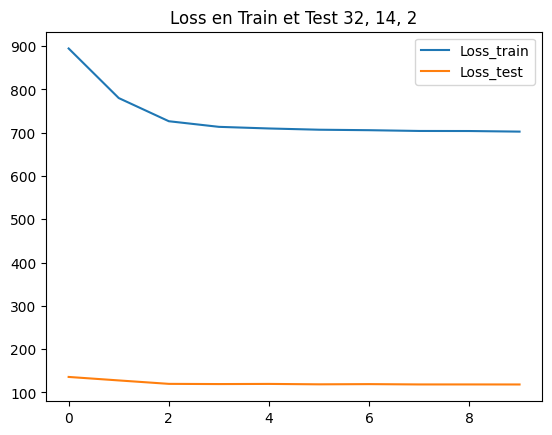

--- Epoch 0 ---
Train loss: 1.9285943106547603
--- Epoch 1 ---
Train loss: 1.7054838163257917
--- Epoch 2 ---
Train loss: 1.6638511185452882
--- Epoch 3 ---
Train loss: 1.6038196259724307
--- Epoch 4 ---
Train loss: 1.5572157424650213
--- Epoch 5 ---
Train loss: 1.5193654766469114
--- Epoch 6 ---
Train loss: 1.5131445904530443
--- Epoch 7 ---
Train loss: 1.5065588348709953
--- Epoch 8 ---
Train loss: 1.507659411633701
--- Epoch 9 ---
Train loss: 1.5023433455526194
Test accuracy 32, 14, 4 : 96.11


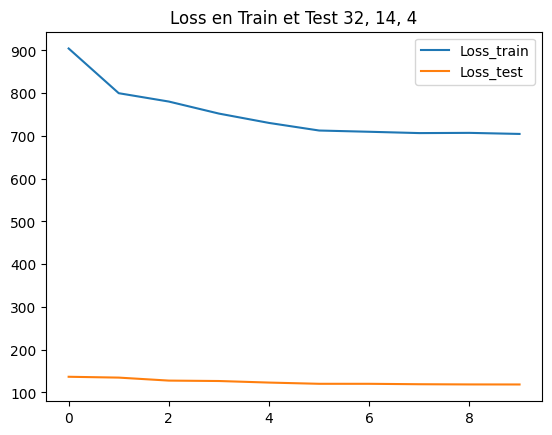

--- Epoch 0 ---
Train loss: 1.9054267653015886
--- Epoch 1 ---
Train loss: 1.6333257343723322
--- Epoch 2 ---
Train loss: 1.5496213113321171
--- Epoch 3 ---
Train loss: 1.5353141898539528
--- Epoch 4 ---
Train loss: 1.5266305576763681
--- Epoch 5 ---
Train loss: 1.5213645709348893
--- Epoch 6 ---
Train loss: 1.520076258350283
--- Epoch 7 ---
Train loss: 1.5141539660089813
--- Epoch 8 ---
Train loss: 1.5095584140911793
--- Epoch 9 ---
Train loss: 1.5072054095359753
Test accuracy 32, 14, 6 : 95.3


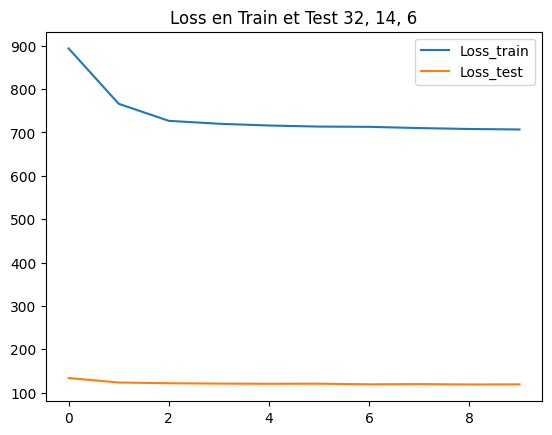

In [23]:
epochs = 10

DEVICE = "cuda:0"

embed_dims = 32
patch_sizes = 7
nb_blocks= [2,4,6]

for nb_blocks in nb_blocks:
  model = ViT(embed_dim, nb_blocks, patch_size).cuda()

  opt = torch.optim.Adam(model.parameters())

  train_loss_liste = []
  test_loss_liste = []
  for epoch in range(epochs):
    train_loss = 0.
    for x, y in train_loader:
      x, y = x.cuda(), y.cuda()

      opt.zero_grad()
      yhat = model(x)
      loss = F.cross_entropy(yhat, y)
      loss.backward()

      opt.step()

      train_loss += loss.item()
    train_loss_liste.append(train_loss)
    with torch.no_grad():
      test_loss = 0
      for x, y in test_loader:
        x, y = x.cuda(), y.cuda()
        yhat = model(x)
        loss = F.cross_entropy(yhat, y)
        test_loss += loss.item()
      test_loss_liste.append(test_loss)

    print(f"--- Epoch {epoch} ---")
    print(f"Train loss: {train_loss / len(train_loader)}")
  acc = eval_model(model, test_loader)
  print(f"Test accuracy {embed_dims}, {patch_size}, {nb_blocks} : {acc}")

  plt.figure()
  plt.plot(train_loss_liste, label='Loss_train')
  plt.plot(test_loss_liste, label='Loss_test')
  plt.title(f'Loss en Train et Test {embed_dims}, {patch_size}, {nb_blocks}')
  plt.legend()
  plt.show()

--- Epoch 0 ---
Train loss: 1.9017587595148635
--- Epoch 1 ---
Train loss: 1.6213580812218347
--- Epoch 2 ---
Train loss: 1.5899258376692913
--- Epoch 3 ---
Train loss: 1.5236986786571902
--- Epoch 4 ---
Train loss: 1.5127241667399782
--- Epoch 5 ---
Train loss: 1.5066932706690546
--- Epoch 6 ---
Train loss: 1.5026502512665445
--- Epoch 7 ---
Train loss: 1.500895112816459
--- Epoch 8 ---
Train loss: 1.498331380297126
--- Epoch 9 ---
Train loss: 1.4969452489922042
Test accuracy 64, 14, 2 : 96.56


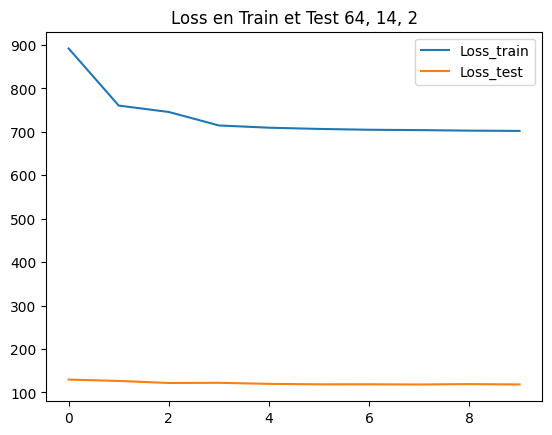

In [19]:
epochs = 10

DEVICE = "cuda:0"

embed_dim = 64
patch_size = 14
nb_blocks= 2
model = ViT(embed_dim, nb_blocks, patch_size).cuda()

opt = torch.optim.Adam(model.parameters())

train_loss_liste = []
test_loss_liste = []
for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()

    opt.zero_grad()
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()
  train_loss_liste.append(train_loss)
  with torch.no_grad():
    test_loss = 0
    for x, y in test_loader:
      x, y = x.cuda(), y.cuda()
      yhat = model(x)
      loss = F.cross_entropy(yhat, y)
      test_loss += loss.item()
    test_loss_liste.append(test_loss)

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")
acc = eval_model(model, test_loader)
print(f"Test accuracy {embed_dim}, {patch_size}, {nb_blocks} : {acc}")

plt.figure()
plt.plot(train_loss_liste, label='Loss_train')
plt.plot(test_loss_liste, label='Loss_test')
plt.title(f'Loss en Train et Test {embed_dim}, {patch_size}, {nb_blocks}')
plt.legend()
plt.show()

# Q8: larger transformers

Try to use bigger transformer, for example the ViT-S from the timm library. Test with and without intialization from imagenet.

a) Load the model using the timm library without pretrained weights. Try to apply it directly on a tensor with the same MNIST images resolution. What it is the problem and why we have it? Explain if we have also such problem with CNNs. As ViT takes RGB images, the input tensor should have 3 channels.

In [20]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.3 MB/s eta 0:00:00


In [21]:
import timm
model = timm.create_model('vit_small_patch16_224', pretrained=False)

In [ ]:
#timm.list_models()

In [22]:
x = torch.randn(32, 3, 28, 28)
model(x).shape

AssertionError: ignored

In [23]:
x = torch.randn(32, 3, 224, 224)
model(x).shape

torch.Size([32, 1000])

b) There is a trcik in timm that allows to use pretrained models with different image resolution and number of classes. Try to reload the model to be able to use on MNIST images:

In [27]:
model = timm.create_model('vit_small_patch16_224', img_size=28, pretrained=True)
x = torch.randn(32, 3, 28, 28)
model(x).shape

torch.Size([32, 1000])

In [29]:
model = timm.create_model('vit_small_patch16_224', img_size=28, in_chans=1, pretrained=True)
x = torch.randn(32, 1, 28, 28)
model(x).shape

torch.Size([32, 1000])

c) redo the training with the pretrained ViT-S





In [30]:
@torch.no_grad()
def eval_model(model, loader, num_channels=1):
  model.eval()
  acc = 0.
  c = 0

  for x, y in loader:
    x, y = x.cuda(), y.cuda()

    yhat = model(x)

    acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
    c += len(x)

  model.train()
  return round(100 * acc / c, 2)

--- Epoch 0 ---
Train loss: 0.797601737638018
--- Epoch 1 ---
Train loss: 0.5280620874499461
--- Epoch 2 ---
Train loss: 0.47086585174872675
--- Epoch 3 ---
Train loss: 0.43761101012418013
--- Epoch 4 ---
Train loss: 0.4000431539407417
--- Epoch 5 ---
Train loss: 0.38096611646573936
--- Epoch 6 ---
Train loss: 0.36671029275922634
--- Epoch 7 ---
Train loss: 0.3590996364222915
--- Epoch 8 ---
Train loss: 0.34044481273780247
--- Epoch 9 ---
Train loss: 0.33347832594217774
--- Epoch 10 ---
Train loss: 0.3231744603561694
--- Epoch 11 ---
Train loss: 0.3097691299882271
--- Epoch 12 ---
Train loss: 0.3046657069087791
--- Epoch 13 ---
Train loss: 0.29153280268345816
--- Epoch 14 ---
Train loss: 0.27921458786484527
--- Epoch 15 ---
Train loss: 0.2720764368645418
--- Epoch 16 ---
Train loss: 0.2630176749120135
--- Epoch 17 ---
Train loss: 0.2567807540996497
--- Epoch 18 ---
Train loss: 0.250567156130444
--- Epoch 19 ---
Train loss: 0.24267672308917237
Test accuracy 32, 7, 2 : 90.13


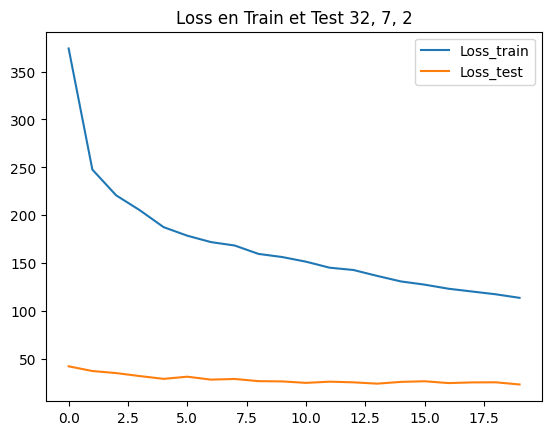

In [34]:
import timm
DEVICE = "cuda:0"
model = timm.create_model('vit_small_patch16_224', img_size=28, in_chans= 1, num_classes =10, pretrained=False)
model.cuda()
model.train()

epochs = 20

opt = torch.optim.Adam(model.parameters())


train_loss_liste = []
test_loss_liste = []
for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()

    opt.zero_grad()
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()
  train_loss_liste.append(train_loss)
  with torch.no_grad():
    test_loss = 0
    for x, y in test_loader:
      x, y = x.cuda(), y.cuda()
      yhat = model(x)
      loss = F.cross_entropy(yhat, y)
      test_loss += loss.item()
    test_loss_liste.append(test_loss)

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")
acc = eval_model(model, test_loader)
print(f"Test accuracy {embed_dim}, {patch_size}, {nb_blocks} : {acc}")

plt.figure()
plt.plot(train_loss_liste, label='Loss_train')
plt.plot(test_loss_liste, label='Loss_test')
plt.title(f'Loss en Train et Test {embed_dim}, {patch_size}, {nb_blocks}')
plt.legend()
plt.show()

c) redo the training but with the ViT-S pretrained on ImageNet

--- Epoch 0 ---
Train loss: 0.5800981211509786
--- Epoch 1 ---
Train loss: 0.3227669766335599
--- Epoch 2 ---
Train loss: 0.27382205115325414
--- Epoch 3 ---
Train loss: 0.24346484134255697
--- Epoch 4 ---
Train loss: 0.2234685253709364
--- Epoch 5 ---
Train loss: 0.20411450674793105
--- Epoch 6 ---
Train loss: 0.19003711234150664
--- Epoch 7 ---
Train loss: 0.17863982736365372
--- Epoch 8 ---
Train loss: 0.16341511801933684
--- Epoch 9 ---
Train loss: 0.1514482733124355
--- Epoch 10 ---
Train loss: 0.1458584560371284
--- Epoch 11 ---
Train loss: 0.13259625326055707
--- Epoch 12 ---
Train loss: 0.13273475025254272
--- Epoch 13 ---
Train loss: 0.12431645093124304
--- Epoch 14 ---
Train loss: 0.1143447387415463
--- Epoch 15 ---
Train loss: 0.1284077684404944
--- Epoch 16 ---
Train loss: 0.10706120509821088
--- Epoch 17 ---
Train loss: 0.09251284773256988
--- Epoch 18 ---
Train loss: 0.09534214940001524
--- Epoch 19 ---
Train loss: 0.09021148382664235
Test accuracy 32, 7, 2 : 91.49


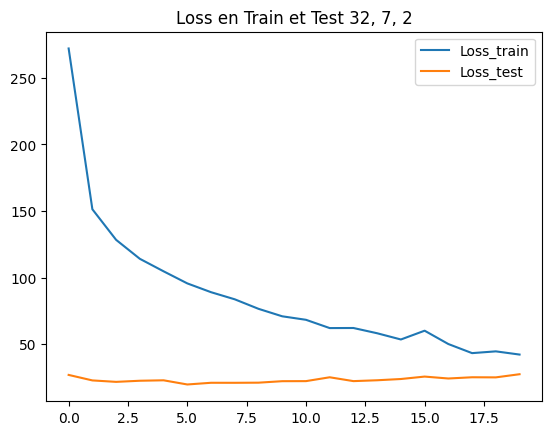

In [35]:
import timm
DEVICE = "cuda:0"
model = timm.create_model('vit_small_patch16_224', img_size=28, in_chans= 1, num_classes =10, pretrained=True)
model.cuda()
model.train()

epochs = 20

opt = torch.optim.Adam(model.parameters())


train_loss_liste = []
test_loss_liste = []
for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()

    opt.zero_grad()
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()
  train_loss_liste.append(train_loss)
  with torch.no_grad():
    test_loss = 0
    for x, y in test_loader:
      x, y = x.cuda(), y.cuda()
      yhat = model(x)
      loss = F.cross_entropy(yhat, y)
      test_loss += loss.item()
    test_loss_liste.append(test_loss)

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")
acc = eval_model(model, test_loader)
print(f"Test accuracy {embed_dim}, {patch_size}, {nb_blocks} : {acc}")

plt.figure()
plt.plot(train_loss_liste, label='Loss_train')
plt.plot(test_loss_liste, label='Loss_test')
plt.title(f'Loss en Train et Test {embed_dim}, {patch_size}, {nb_blocks}')
plt.legend()
plt.show()

d) Comment the final results and provide some ideas on how to make transformer work on small datasets. You can take inspiration from some recent work.